In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import mlflow

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [7]:
with open('train_config2.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [8]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [9]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date, max_evals = 1000, 
               data_source = None, mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = "SEIR"
    

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'Train1')) 
    
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
        
    model_params['model_parameters'] = dict()
    model_params['model_parameters'].update(finalResults['best_params'])
    model_params['model_parameters'].update(finalResults['latent_params'])
    model_params['model_parameters']['MAPE'] = finalResults['train_metric_results'][0]['value']
    
    return params, metrics, model_params

In [10]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 100,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

t = 10.90                                              
t = 10.90                                              
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                               

t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
100%|██████████| 100/100 [00:09<00:00, 10.44trial/s, best loss: 9.63929865054293]
Best fit: {'EbyCRatio': 0.13522170804009193, 'IbyCRatio': 0.46401345669105765, 'infectious_period': 3.5718812920349032, 'r0': 2.8745895820183383}
Best Loss: 9.63929865054293
t = 10.90
t = 10.90


In [11]:
params

{'data_source': None,
 'region': 'mumbai',
 'region_type': 'district',
 'run_day': '4/17/20',
 'test_end_date': '4/22/20',
 'test_start_date': '4/18/20',
 'train1_end_date': '4/17/20',
 'train1_start_date': '4/8/20',
 'train2_end_date': '4/22/20',
 'train2_start_date': '4/13/20'}

In [12]:
metrics

{'TestMAPE': 12.498837562638844,
 'TestRMLSE': 0.14590600061802933,
 'Train1MAPE': 7.178444062160496,
 'Train1RMLSE': 0.08162828387187807,
 'Train1_EbyCRatio': 1.3495369347798487,
 'Train1_IbyCRatio': 0.7728544485205429,
 'Train1_infectious_period': 2.8349670084009917,
 'Train1_r0': 1.3533854036492317,
 'Train2MAPE': 9.63929865054293,
 'Train2RMLSE': 0.11840621822363825,
 'Train2_EbyCRatio': 0.13522170804009193,
 'Train2_IbyCRatio': 0.46401345669105765,
 'Train2_infectious_period': 3.5718812920349032,
 'Train2_r0': 2.8745895820183383}

In [13]:
model_params

{'model_parameters': {'EbyCRatio': 0.13522170804009193,
  'IbyCRatio': 0.46401345669105765,
  'LatentEbyCRatio': {'4/12/20': 0.13522170804009193,
   '4/22/20': 0.513375500655202},
  'LatentIbyCRatio': {'4/12/20': 0.46401345669105765,
   '4/22/20': 0.2696949352066476},
  'MAPE': 9.63929865054293,
  'infectious_period': 3.5718812920349032,
  'r0': 2.8745895820183383},
 'model_type': 'SEIR',
 'region': 'mumbai',
 'region_type': 'district'}

In [14]:
model_params['model_parameters']['incubation_period'] = 5

In [15]:
model_params

{'model_parameters': {'EbyCRatio': 0.13522170804009193,
  'IbyCRatio': 0.46401345669105765,
  'LatentEbyCRatio': {'4/12/20': 0.13522170804009193,
   '4/22/20': 0.513375500655202},
  'LatentIbyCRatio': {'4/12/20': 0.46401345669105765,
   '4/22/20': 0.2696949352066476},
  'MAPE': 9.63929865054293,
  'incubation_period': 5,
  'infectious_period': 3.5718812920349032,
  'r0': 2.8745895820183383},
 'model_type': 'SEIR',
 'region': 'mumbai',
 'region_type': 'district'}

In [16]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [17]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

t = 10.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [18]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max
0,4/13/20,428.933149,510.198134,826.840369,22.071714,1359.110217,132.651515,461.018612,559.377656,119.864839,145.438191,747.138756,906.541981,19.944156,24.199273,1228.101524,1490.118910
1,4/14/20,606.520547,477.233251,960.564898,25.641363,1463.439512,124.080645,431.231313,523.235189,112.120141,136.041149,867.973179,1053.156618,23.169715,28.113010,1322.374207,1604.504817
2,4/15/20,744.355139,479.701232,1090.297904,29.104461,1599.103598,124.722320,433.461398,525.941067,112.699963,136.744677,985.200833,1195.394975,26.298996,31.909927,1444.961226,1753.245969
3,4/16/20,865.235693,503.443082,1224.028243,32.674265,1760.145590,130.895201,454.914699,551.971464,118.277822,143.512581,1106.040505,1342.015981,29.524695,35.823835,1590.479900,1929.811280
4,4/17/20,980.309761,542.132290,1366.214320,36.469787,1944.816396,140.954395,489.874540,594.390041,127.367380,154.541411,1234.520841,1497.907798,32.954355,39.985218,1757.349736,2132.283057
5,4/18/20,1098.076104,591.314784,1520.597020,40.590886,2152.502689,153.741844,534.316186,648.313381,138.922208,168.561479,1374.022132,1667.171908,36.678209,44.503562,1945.016527,2359.988852
6,4/19/20,1222.461202,649.694418,1689.609744,45.102519,2384.406681,168.920549,587.068433,712.320403,152.637793,185.203305,1526.743215,1852.476274,40.754952,49.450085,2154.566600,2614.246762
7,4/20/20,1356.698902,716.576064,1875.601545,50.067392,2642.245001,186.309777,647.503157,785.648971,168.350821,204.268732,1694.806710,2056.396379,45.241247,54.893538,2387.551114,2896.938888
8,4/21/20,1503.975805,791.450442,2081.050072,55.551645,2928.052158,205.777115,715.160170,867.740713,185.941644,225.612585,1880.451441,2281.648704,50.196856,60.906434,2645.808466,3210.295850
9,4/22/20,1665.786520,875.098611,2308.062013,61.611512,3244.772136,227.525639,790.745242,959.451980,205.593763,249.457515,2085.581023,2530.543004,55.672594,67.550429,2931.998859,3557.545413


In [19]:
def get_observations_in_range(region_name, region_type, 
                              start_date, end_date,
                              obs_type = 'confirmed'):
    """
        Return a list of counts of obs_type cases
        from the region in the specified date range.
    """
    observations = DataFetcherModule.get_observations_for_region(region_type, region_name)
    observations_df = observations[observations['observation'] == obs_type]
    
    start_date = datetime.strptime(start_date, '%m/%d/%y')
    end_date = datetime.strptime(end_date, '%m/%d/%y')
    delta = (end_date - start_date).days
    days = []
    for i in range(delta + 1):
        days.append((start_date + timedelta(days=i)).strftime('%-m/%-d/%-y'))
    
    # Fetch observations in the date range
    observations_df = observations_df[days]
    
    # Transpose the df to get the
    # observations_df.shape = (num_days, 1)
    observations_df = observations_df.reset_index(drop=True).transpose()
    
    # Rename the column to capture observation type
    # Note that the hardcoded 0 in the rename comes from the reset_index
    # from the previous step
    observations = observations_df[0].to_list()
    return observations

In [20]:
observations = get_observations_in_range('mumbai', 'district', '4/13/20', '4/22/20')

In [21]:
forecast_df['actual_confirmed'] = observations

In [22]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max,actual_confirmed
0,4/13/20,428.933149,510.198134,826.840369,22.071714,1359.110217,132.651515,461.018612,559.377656,119.864839,145.438191,747.138756,906.541981,19.944156,24.199273,1228.101524,1490.118910,1540.0
1,4/14/20,606.520547,477.233251,960.564898,25.641363,1463.439512,124.080645,431.231313,523.235189,112.120141,136.041149,867.973179,1053.156618,23.169715,28.113010,1322.374207,1604.504817,1756.0
2,4/15/20,744.355139,479.701232,1090.297904,29.104461,1599.103598,124.722320,433.461398,525.941067,112.699963,136.744677,985.200833,1195.394975,26.298996,31.909927,1444.961226,1753.245969,1896.0
3,4/16/20,865.235693,503.443082,1224.028243,32.674265,1760.145590,130.895201,454.914699,551.971464,118.277822,143.512581,1106.040505,1342.015981,29.524695,35.823835,1590.479900,1929.811280,2073.0
4,4/17/20,980.309761,542.132290,1366.214320,36.469787,1944.816396,140.954395,489.874540,594.390041,127.367380,154.541411,1234.520841,1497.907798,32.954355,39.985218,1757.349736,2132.283057,2085.0
5,4/18/20,1098.076104,591.314784,1520.597020,40.590886,2152.502689,153.741844,534.316186,648.313381,138.922208,168.561479,1374.022132,1667.171908,36.678209,44.503562,1945.016527,2359.988852,2268.0
6,4/19/20,1222.461202,649.694418,1689.609744,45.102519,2384.406681,168.920549,587.068433,712.320403,152.637793,185.203305,1526.743215,1852.476274,40.754952,49.450085,2154.566600,2614.246762,2724.0
7,4/20/20,1356.698902,716.576064,1875.601545,50.067392,2642.245001,186.309777,647.503157,785.648971,168.350821,204.268732,1694.806710,2056.396379,45.241247,54.893538,2387.551114,2896.938888,2912.0
8,4/21/20,1503.975805,791.450442,2081.050072,55.551645,2928.052158,205.777115,715.160170,867.740713,185.941644,225.612585,1880.451441,2281.648704,50.196856,60.906434,2645.808466,3210.295850,2913.0
9,4/22/20,1665.786520,875.098611,2308.062013,61.611512,3244.772136,227.525639,790.745242,959.451980,205.593763,249.457515,2085.581023,2530.543004,55.672594,67.550429,2931.998859,3557.545413,3145.0


In [23]:
def plot(model_params, run_day, forecast_start_date, forecast_end_date, 
         actual_start_date, plot_name = 'default.png'):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    pdjson = ForecastingModule.from_config(evalConfig)
    pd_df = pd.read_json(pdjson)
    pd_df = pd_df.set_index('prediction_type')
    pd_df = pd_df.transpose()
    pd_df = pd_df.reset_index()
    pd_df = pd_df[5:]
    pd_df['index'] = pd.to_datetime(pd_df['index'])
    pd_df = pd_df.sort_values(by=['index'])

    actual = DataFetcherModule.get_observations_for_region(model_params['region_type'], model_params['region'])
    actual = actual.set_index('observation')
    actual = actual.transpose()
    actual = actual.reset_index()
    start = actual.index[actual['index'] == actual_start_date].tolist()[0]
    actual = actual[start : ]
    actual['index'] = pd.to_datetime(actual['index'])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title(model_params['region'])
    ax.plot(actual['index'], actual['confirmed'], color='green', label="observed")
    ax.plot(pd_df['index'], pd_df['confirmed_mean'], color='orange', label="predicted")
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=0)
    ax.legend()
    fig.tight_layout()
    
    plt.savefig(plot_name)

In [24]:
dates_plot = {'train1_start_date': '4/30/20', 'train1_end_date': '5/6/20',
              'train2_start_date': '5/7/20', 'train2_end_date': '5/13/20',
              'test_start_date': '5/7/20', 'test_end_date': '5/13/20', 'test_run_day': '5/6/20',
              'forecast_start_date': '5/7/20', 'forecast_run_day': '5/6/20', 'forecast_end_date': '5/13/20'}

t = 7.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/nayana/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


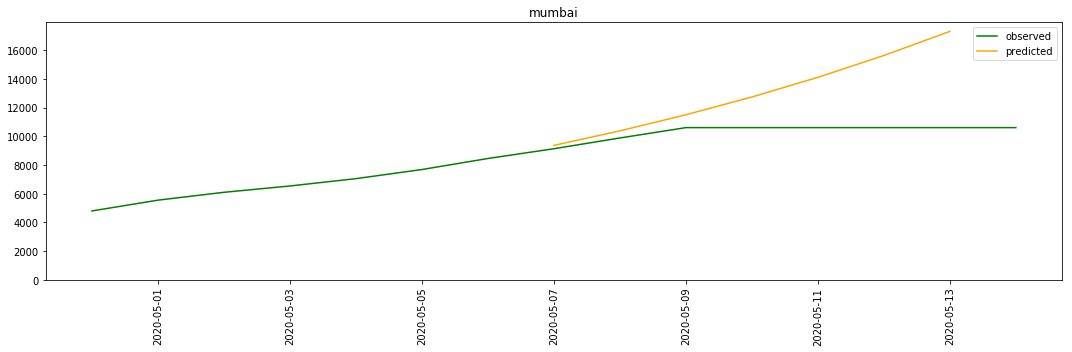

In [25]:
%matplotlib inline
plot(model_params, dates_plot['forecast_run_day'], 
     dates_plot['forecast_start_date'],dates_plot['forecast_end_date'], 
     dates_plot['train1_start_date'], plot_name = 'default.png')

In [26]:
def train_eval_forecast(region, region_type, 
                        train1_start_date, train1_end_date, 
                        train2_start_date, train2_end_date,
                        test_run_day, test_start_date, test_end_date, 
                        forecast_run_day, forecast_start_date, forecast_end_date,
                        max_evals = 1000, 
                        data_source = None, mlflow_log = True, name_prefix = None,
                        plot_actual_vs_predicted = False, plot_name = 'default.png'):
    """
        Run train, evaluation and generate forecasts as a dataframe.
        
        If plot_actual_vs_predicted is set to True,
        we first check if the forecast_end_date is prior to the current date
        so that we have actual_confirmed cases and then plot the predictions.
    """
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    
    plot(model_params, forecast_run_day, forecast_start_date, 
         forecast_end_date, actual_start_date=train1_start_date, plot_name=plot_name)
    
    return forecast_df, params, metrics, model_params

In [27]:
def dates_to_str(dates):
    str_dates = dict()
    for date in dates:
        str_dates[date] = dates[date].strftime("%-m/%-d/%y")
    return str_dates

In [28]:
def set_dates(train2_end_date, forecast_end_date):
    t = datetime.now().date()

    dates = defaultdict()

    dates["train1_start_date"] = (t - timedelta(14))
    dates["train1_end_date"] = (t - timedelta(8))

    if train2_end_date is None:
        dates["train2_start_date"] = (t - timedelta(7))
        dates["train2_end_date"] = (t - timedelta(1))
    else:
        dates["train2_end_date"] = datetime.strptime(train2_end_date, "%m/%d/%y")
        dates["train2_start_date"] = dates["train2_end_date"] - timedelta(6)

    dates["test_start_date"] = dates['train2_start_date']
    dates["test_end_date"] = dates['train2_end_date']
    dates["test_run_day"] = dates["test_start_date"] - timedelta(1)

    dates["forecast_start_date"] = dates["test_start_date"]
    dates["forecast_run_day"] = dates["forecast_start_date"] - timedelta(1)
    dates["forecast_end_date"] = datetime.strptime(forecast_end_date, "%m/%d/%y")

    dates = dates_to_str(dates)
    print(dates)

    return dates

In [30]:
mlflow.set_tracking_uri("http://ec2-54-175-207-176.compute-1.amazonaws.com")
mlflow.set_experiment("seir_trial")

{'train1_start_date': '4/30/20', 'train1_end_date': '5/6/20', 'train2_start_date': '5/7/20', 'train2_end_date': '5/13/20', 'test_start_date': '5/7/20', 'test_end_date': '5/13/20', 'test_run_day': '5/6/20', 'forecast_start_date': '5/7/20', 'forecast_run_day': '5/6/20', 'forecast_end_date': '5/20/20'}
t = 7.90                                               
t = 7.90                                               
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90       

t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
100%|██████████| 100/100 [00:07<00:00, 13.63trial/s, best loss: 6.221450228809874]
Best fit: {'EbyCRatio': 0.28893793084429964, 'IbyCRatio': 0.04545164089570103, 'infectious_period': 4.980557661454042, 'r0': 2.6269858130377757}
Best Loss: 6.221450228809874
t = 7

/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


t = 14.90
{'train1_start_date': '4/30/20', 'train1_end_date': '5/6/20', 'train2_start_date': '5/7/20', 'train2_end_date': '5/13/20', 'test_start_date': '5/7/20', 'test_end_date': '5/13/20', 'test_run_day': '5/6/20', 'forecast_start_date': '5/7/20', 'forecast_run_day': '5/6/20', 'forecast_end_date': '5/20/20'}
t = 7.90                                               
t = 7.90                                               
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                        
t = 7.90                                                                        
t = 7

t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
100%|██████████| 100/100 [00:07<00:00, 12.65trial/s, best loss: 2.031392082748608]
Best fit: {'EbyCRatio': 0.17468524527624812, 'IbyCRatio': 0.06643112297519149, 'infectious_period': 3.925402415953043, 'r0': 0.8495192479709758}
Best Loss: 2.031392082748608
t = 7.90
t = 7.90
t = 38.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


t = 14.90


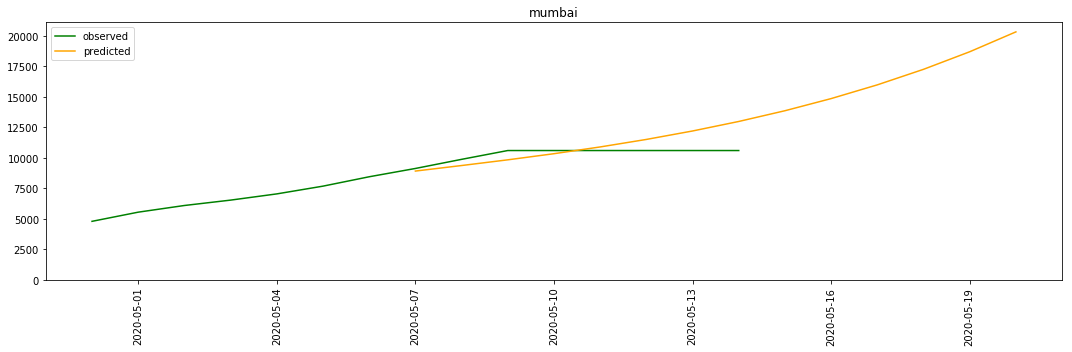

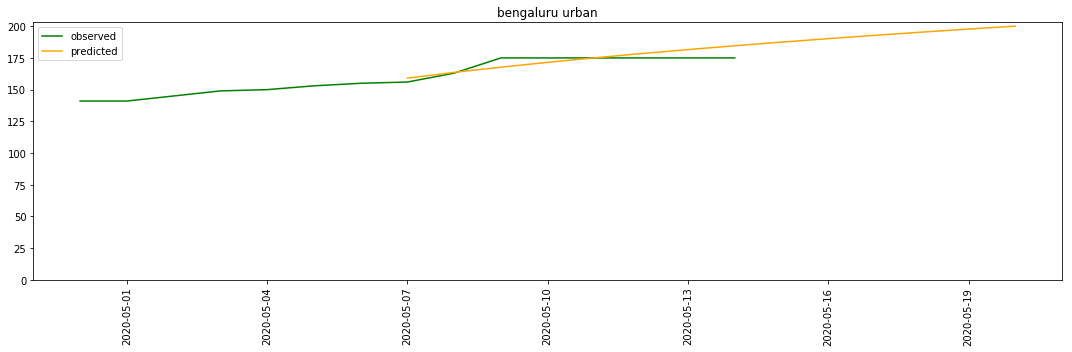

In [31]:
trials = [{'region':'mumbai','region_type':'district','forecast_end_date':'5/20/20'},
          {'region':'bengaluru urban','region_type':'district','forecast_end_date':'5/20/20'}]

for trial in trials:
    region = trial['region']
    region_type = trial['region_type']
    forecast_end_date = trial['forecast_end_date']
    name_prefix = "{}_{}_{}".format(region, region_type, datetime.now())
    plot_name = '{}_{}_{}.png'.format(region, forecast_end_date.replace('/', '-'), datetime.now())
    
    dates = set_dates(None, forecast_end_date)

    with mlflow.start_run():
        forecast_df, params, metrics, model_params = train_eval_forecast(region, region_type, 
                                                                         dates['train1_start_date'], dates['train1_end_date'], 
                                                                         dates['train2_start_date'], dates['train2_end_date'],
                                                                         dates['test_run_day'], dates['test_start_date'], dates['test_end_date'], 
                                                                         dates['forecast_run_day'], dates['forecast_start_date'], dates["forecast_end_date"],
                                                                         max_evals = 100, 
                                                                         mlflow_log = True, name_prefix = name_prefix,
                                                                         plot_actual_vs_predicted = 'True', 
                                                                         plot_name = plot_name)

        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.log_artifact(plot_name)
        mlflow.log_artifact('train_config.json')
        mlflow.log_artifact('train1_output.json')
        mlflow.log_artifact('test_output.json')
        mlflow.log_artifact('train2_output.json')